In [1]:
import os
import sys
#hacky spyder crap
#sys.path.insert(1, 'C:\\Users\\EGR\\AppData\\Roaming\\Python\\Python37\\site-packages')
sys.path.insert(1, 'D:\\projects\\FUI\\src')
sys.path.insert(1, 'D:\\projects\\FUI\\env\\Lib\\site-packages')
sys.path.insert(1, 'C:\\Users\\EGR\\AppData\\Roaming\\Python\\Python37\\site-packages')
import pickle
import json
import glob
import re
import copy
import h5py
import codecs
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns


from gensim.models import KeyedVectors
from cycler import cycler
from datetime import datetime
from nltk.stem.snowball import SnowballStemmer
from multiprocessing import Pool
from functools import partial
from matplotlib import pyplot as plt

#local imports
from fui.cluster import ClusterTree
from fui.indices import merge_lda_u, LDAIndexer
from fui.utils import dump_pickle, dump_csv, params, read_hdf, read_h5py


Last month:                   idx  idx_norm
                mean          
date                          
2019-03-31  0.000009  0.373551


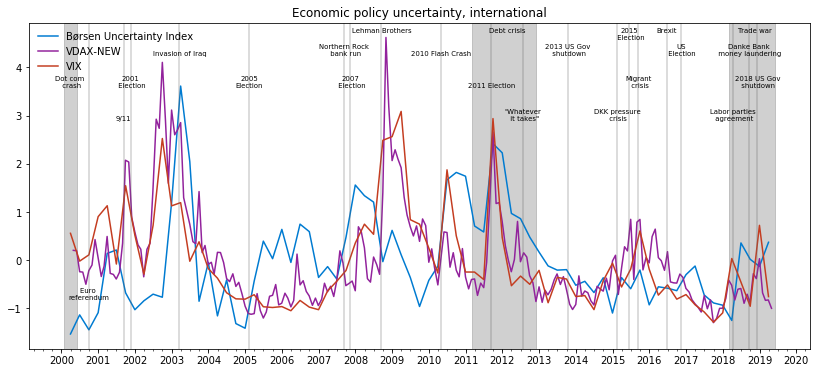

Last month:                   idx  idx_norm
                mean          
date                          
2019-03-31 -0.000006 -0.612687


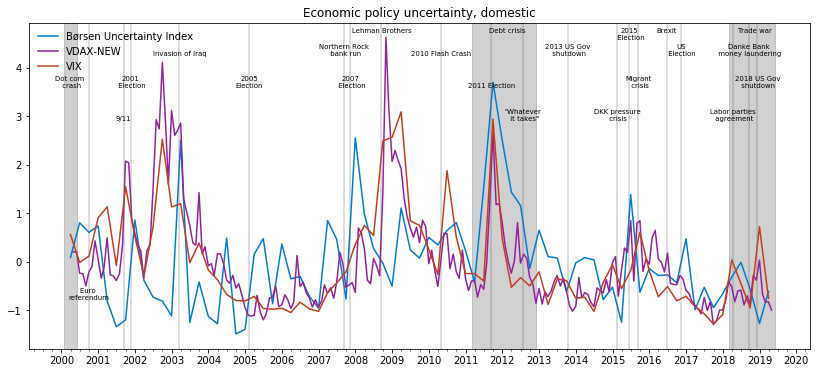

Last month:                   idx  idx_norm
                mean          
date                          
2019-03-31 -0.000004 -0.119342


,idx,idx_norm
,mean,
date,,
2000-03-31,-4.487444e-05,-1.249339
2000-06-30,-2.754662e-05,-0.766919
2000-09-30,-2.463738e-05,-0.685924
2000-12-31,-1.601738e-05,-0.445936
2001-03-31,-1.384461e-05,-0.385445
...,...,...
2018-03-31,-4.316924e-05,-1.201865
2018-06-30,-7.810470e-07,-0.021745


In [14]:
years = mdates.YearLocator()

international = LDAIndexer(name='ep_int')
international.build(num_topics=80,topics=['EP_int'],topic_thold=0.5,frq='Q')
international.plot_index(title='Economic policy uncertainty, international', plot_hh=False)

domestic = LDAIndexer(name='ep_dk')
domestic.build(num_topics=80,topics=['EP_dk'],topic_thold=0.5,frq='Q')
domestic.plot_index(title='Economic policy uncertainty, domestic', plot_hh=False)

both = LDAIndexer(name='ep_all')
both.build(num_topics=80,topics=['EP'],topic_thold=0.5,frq='Q')

In [22]:
import scipy
#scipy.signal.detrend(domestic.idx)
domestic.idx['idx'] = scipy.signal.detrend(domestic.idx['idx'], axis=0)

In [23]:
domestic.idx['idx']

,mean
date,
2000-01-31,-0.000010
2000-02-29,0.000018
2000-03-31,-0.000004
2000-04-30,0.000053
2000-05-31,-0.000018
...,...
2018-12-31,-0.000015
2019-01-31,-0.000006
2019-02-28,-0.000003


In [11]:
dom = domestic.labels['EP_dk']
intl = international.labels['EP_int']
df = merge_lda_u()
df['main'] = df['topics'].apply(lambda x : np.argmax(x))
df['u_share'] = ((df['n_count']+df['u_count'])/df['word_count'])*1000


df['idx_dom'] = df['topics'].apply(
    lambda x : np.array([j for i,j in enumerate(x) if (i in dom) and (j >= 0.5)]).sum())
#df['idx_dom'] = df['idx_dom']*df['u_share']
df['idx_intl'] = df['topics'].apply(
    lambda x : np.array([j for i,j in enumerate(x) if (i in intl) and (j >= 0.5)]).sum())
#df['idx_intl'] = df['idx_intl']*df['u_share']

df.set_index('ArticleDateCreated', inplace=True, drop=False)
df = df["2000-01-01":"2019-04-30"]  

In [25]:
mcount_above = df.loc[df['idx_intl'] > 0].groupby(
    [pd.Grouper(key='ArticleDateCreated', freq='M')]
).agg('count')


mcount = df.groupby(
    [pd.Grouper(key='ArticleDateCreated', freq='M')]
).agg('count')


In [26]:
mcount_above = mcount_above.join(mcount, rsuffix='_all')
mcount_above['share'] = mcount_above['article_id'].divide(mcount_above['article_id_all'], axis='index')

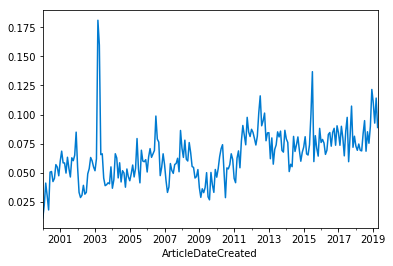

In [29]:
mcount_above['share'].plot()

<Figure size 432x288 with 0 Axes>

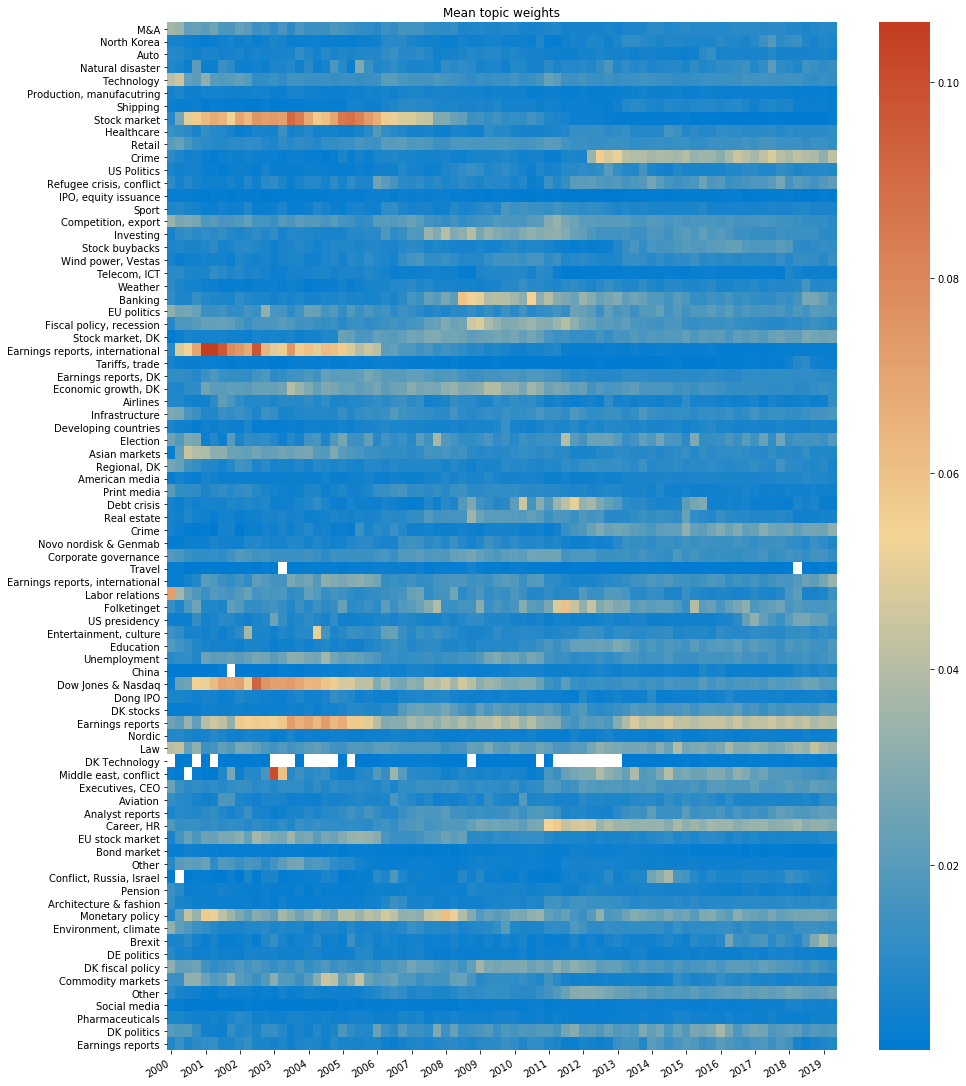

In [71]:

dft = agg_topics.transpose()
dft.columns = dft.columns.strftime('%Y')

with codecs.open(params().paths['topic_labels']+'labels80.json', 'r', encoding='utf-8-sig') as f:
    labels = json.load(f)
    glabs = [v[0] for v in labels.values()]

nbcm = LinearSegmentedColormap.from_list(
        'nbcm', [(0/255,123/255,209/255),  (244/255,212/255,149/255), (196/255,61/255,33/255)], N=200)

nbcm.set_under(color='#ffffff')    
nbcm.set_bad(color='#ffffff')  

plt.clf()
fig, ax = plt.subplots(1,1, figsize=(15,21))
ax = sns.heatmap(dft, cmap=nbcm, linewidths=0, annot=False, xticklabels=4, yticklabels=glabs, vmin=0.001)
ax.set_xlabel(None)
ax.set_title("Mean topic weights")
#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.savefig(f'data/indices/all_topics_over_time_heatmap.pdf', dpi=300)
plt.show()
plt.close()


In [67]:
dft = agg_topics.transpose()
dft.columns = dft.columns.strftime('%Y-%m-%d')

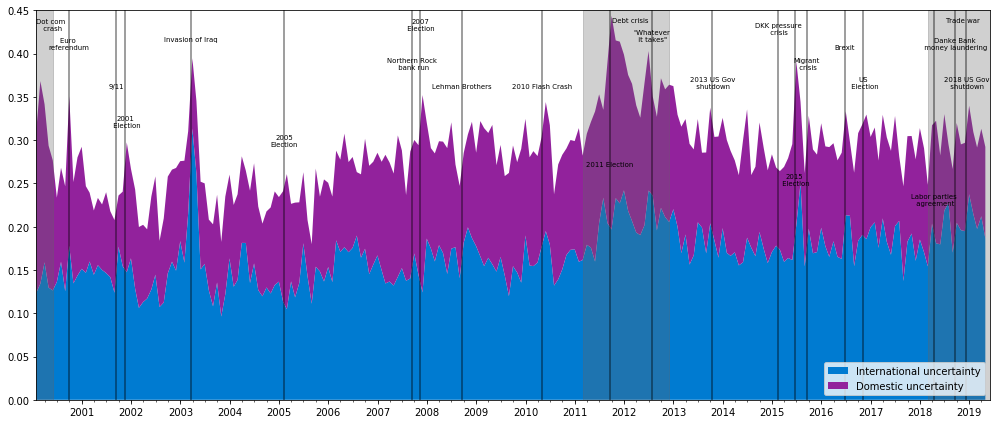

In [40]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator((1, 4, 7, 10))
years_fmt = mdates.DateFormatter('%Y')


df_stack = pd.concat([international.idx['idx'].rename('International'), domestic.idx['idx'].rename('Domestic')], axis=1)

out_path = params().paths['indices']
idx_col = 'idx'

c = cycler(
    'color',
    [
        (0/255, 123/255, 209/255),
        (146/255, 34/255, 156/255),
        (196/255, 61/255, 33/255),
        (223/255, 147/255, 55/255),
        (176/255, 210/255, 71/255),
        (102/255, 102/255, 102/255)
    ])
plt.rcParams["axes.prop_cycle"] = c

fig, ax = plt.subplots(figsize=(14,6))
#ax.plot(international.idx.index, international.idx[idx_col], label='International uncertainty')
#ax.plot(domestic.idx.index, domestic.idx[idx_col], label='Domestic uncertainty')
#ax.plot(both.idx.index, both.idx[idx_col], label='Composite uncertainty')

ax.stackplot(df_stack.index,  df_stack.transpose())
ax.margins(0)
ax.legend(labels=['International uncertainty','Domestic uncertainty'], loc="lower right")
ax.set_ylim(0, 0.45)

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)


ax.axvspan(xmin=datetime(2000,1,31), xmax=datetime(2000,5,31), 
           color=(102/255, 102/255, 102/255), alpha=0.3)
ax.annotate("Dot com \n crash", xy=(datetime(2000,5,20), 0.95),  
            xycoords=('data', 'axes fraction'), fontsize='x-small', ha='center')
ax.axvspan(xmin=datetime(2011,3,1), xmax=datetime(2012,11,30), 
           color=(102/255, 102/255, 102/255), alpha=0.3)
ax.annotate("Debt crisis", xy=(datetime(2012,2,15), 0.97),  
            xycoords=('data', 'axes fraction'), fontsize='x-small', ha='center')
ax.axvspan(xmin=datetime(2018,3,1), xmax=datetime(2019,5,31), 
           color=(102/255, 102/255, 102/255), alpha=0.3)
ax.annotate("Trade war", xy=(datetime(2018,11,15), 0.97), 
            xycoords=('data', 'axes fraction'), fontsize='x-small', ha='center')

dates_dict = {'Euro \nreferendum': ['2000-09-28',0.9],
              '9/11': ['2001-09-11',0.8],
              '2001\n Election': ['2001-11-20',0.7],
              'Invasion of Iraq': ['2003-03-19',0.92],
              '2005\nElection': ['2005-02-08',  0.65 ]  ,
              'Northern Rock\n bank run': ['2007-09-14',0.85],
              '2007\n Election': ['2007-11-13',0.95],
              'Lehman Brothers': ['2008-09-15', 0.8],
              '2010 Flash Crash': ['2010-05-06',0.8],
              '2011 Election': ['2011-09-15',0.6],
              '"Whatever\n it takes"': ['2012-07-26', 0.92],
              '2013 US Gov\n shutdown': ['2013-10-15', 0.8],
              'DKK pressure\n crisis': ['2015-02-15',0.94],
              '2015\n Election': ['2015-06-18',0.55],
              'Migrant\n crisis': ['2015-09-15',0.85],
              'Brexit': ['2016-06-23',0.9],
              'US\n Election': ['2016-11-08',0.8],
              'Labor parties\n agreement': ['2018-04-15',0.5],
              'Danke Bank\n money laundering': ['2018-09-15',0.9],
              '2018 US Gov\n shutdown': ['2018-12-10',0.8]}

heights = [0.9, 0.7, 0.8, 0.9, 0.8, 0.9, 0.8, 
           0.97, 0.9, 0.8, 0.7, 0.9, 0.7, 0.95, 0.8,
           0.97, 0.9, 0.7, 0.9, 0.8]

for l, d, h in zip(dates_dict.keys(), [i[0] for i in dates_dict.values()], [i[1] for i in dates_dict.values()]):
    d = datetime.strptime(d, "%Y-%m-%d")
    ax.axvline(x=d, color=(0/255, 0/255, 0/255), alpha=0.5)
    ax.annotate(l, xy=(d, h),  xycoords=('data', 'axes fraction'), 
                fontsize='x-small', ha='center')
#corr = _calc_corr(vix,idx[idx_name])
#ax.text(0.80, 0.95, 'Correlation with VIX: %.2f' % round(corr,2) , transform=ax.transAxes)
plt.tight_layout()
plt.show()
fig.savefig(f'{out_path}stacked_index_plot.png', dpi=300)

In [41]:
agg_share = df[['u_share','u_count', 'word_count']].groupby(
    [pd.Grouper(level='ArticleDateCreated', freq='D')]
).agg('mean')
agg_share = agg_share.dropna()

agg_share['rolling'] = agg_share['u_share'].rolling('30d').mean()


In [39]:
agg_share = df[['u_count', 'word_count']].groupby(
    [pd.Grouper(level='ArticleDateCreated', freq='D')]
).agg('sum')
agg_share['u_share'] = (agg_share['u_count']/agg_share['word_count'])*1000
agg_share = agg_share.dropna()
agg_share['rolling'] = agg_share['u_share'].rolling('30d').mean()

In [40]:
agg_share.head(-20)

,u_count,word_count,u_share,rolling
ArticleDateCreated,,,,
2000-01-03,0,2707,0.000000,0.000000
2000-01-04,0,2246,0.000000,0.000000
2000-01-05,0,1577,0.000000,0.000000
2000-01-06,0,2355,0.000000,0.000000
2000-01-07,2,1838,1.088139,0.217628
...,...,...,...,...
2019-04-06,6,14693,0.408358,0.578959
2019-04-07,12,20379,0.588841,0.580302
2019-04-08,35,65818,0.531769,0.576906


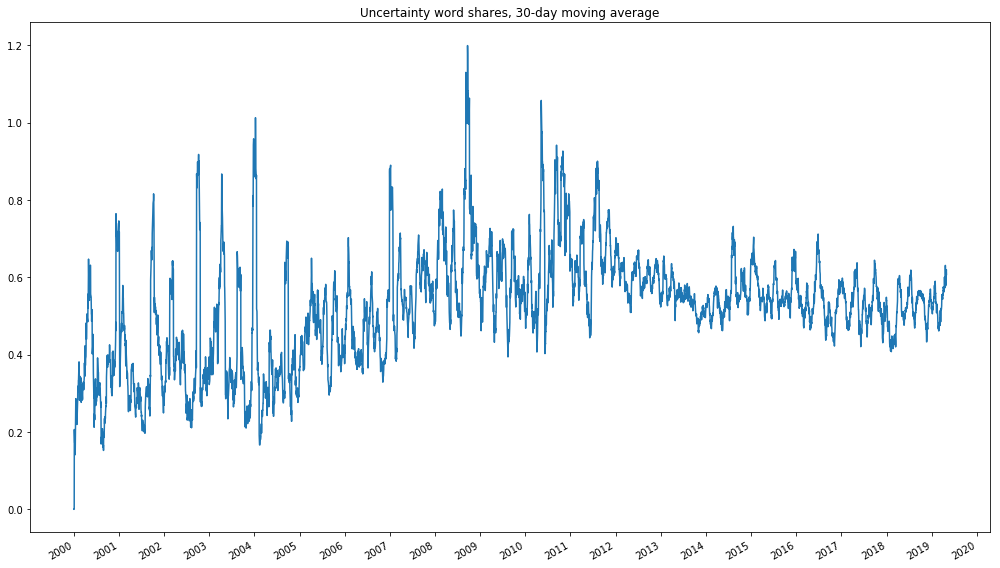

In [43]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.plot(agg_share.index, agg_share['rolling'])
ax.set_xlabel(None)
ax.set_title("Uncertainty word shares, 30-day moving average")
fig.autofmt_xdate()
ax.xaxis.set_major_locator(years)
plt.tight_layout()
plt.savefig(f'u_shares_over_time_new.pdf', dpi=300)
plt.show()

In [73]:
import os
import pandas as pd
import pickle
import re
import h5py
import numpy as np
import warnings
import glob
import html


"""
Loads the data from CSV and performs some basic cleaning. Essentially the
cleaning removes corrupted lines.
"""
# Load the data
csvpath = \
    params().paths['boersen_articles']+params().filenames['boersen_csv']
df = pd.read_csv(csvpath, sep=';', encoding='UTF-16', error_bad_lines=False)

print('Dropping articles with NaN content...')
start_n = df.shape[0] 
# df = df[df['Title']!='test']
df = df[df['ArticleContents'].apply(type) == str]
end_n = df.shape[0]
print('Dropped {} articles with NaN content'.format(start_n-end_n))

print('Dropping articles with SectionName not being string...')
start_n = df.shape[0] 
df = df[df['SectionName'].apply(type) == str]
df = df[df['SectionName'].str.isnumeric() == False]
end_n = df.shape[0]
print('Dropped {} articles with ID as SectionName'.format(start_n-end_n))

df['ArticleDateCreated'] = pd.to_datetime(df['ArticleDateCreated'], format='%Y-%m-%d')


b'Skipping line 356209: expected 14 fields, saw 26\nSkipping line 362883: expected 14 fields, saw 26\nSkipping line 363564: expected 14 fields, saw 26\nSkipping line 368715: expected 14 fields, saw 26\nSkipping line 380336: expected 14 fields, saw 26\nSkipping line 390766: expected 14 fields, saw 26\nSkipping line 390772: expected 14 fields, saw 26\nSkipping line 390773: expected 14 fields, saw 26\nSkipping line 391710: expected 14 fields, saw 26\n'
b'Skipping line 396164: expected 14 fields, saw 26\nSkipping line 398416: expected 14 fields, saw 26\nSkipping line 400339: expected 14 fields, saw 26\nSkipping line 412393: expected 14 fields, saw 26\nSkipping line 413690: expected 14 fields, saw 26\nSkipping line 426457: expected 14 fields, saw 26\nSkipping line 430740: expected 14 fields, saw 25\nSkipping line 434030: expected 14 fields, saw 26\nSkipping line 445846: expected 14 fields, saw 26\n'
b'Skipping line 472984: expected 14 fields, saw 26\nSkipping line 476010: expected 14 fields

In [104]:
counts = df.groupby([pd.Grouper(key='ArticleDateCreated', freq='M')])['Supplier'].apply(lambda x: x.value_counts())
counts = counts.unstack(fill_value=0)

df['word_count'] = df['ArticleContents'].str.count(' ') + 1
word_counts = df.groupby([pd.Grouper(key='ArticleDateCreated', freq='M'), 'Supplier'])['word_count'].agg('mean')
word_counts = word_counts.unstack(fill_value=0)


In [106]:
word_counts.head(20)
#df.groupby(
#    [pd.Grouper(key='ArticleDateCreated', freq='M')]
#).agg('count')


Supplier,Blog,Bo Bedre,Børsen,Børsen Weekend,Direkt-SE,E-Avis,E-Avis arkiv,Magasinet Pleasure,Ritzau,TDN
ArticleDateCreated,,,,,,,,,,
1996-06-30,0.0,0.0,0.000000,0.0,0.0,0.0,39.835366,0.0,0.0,0.0
1996-07-31,0.0,0.0,0.000000,0.0,0.0,0.0,39.501664,0.0,0.0,0.0
1996-08-31,0.0,0.0,0.000000,0.0,0.0,0.0,39.820494,0.0,0.0,0.0
1996-09-30,0.0,0.0,0.000000,0.0,0.0,0.0,39.559567,0.0,0.0,0.0
1996-10-31,0.0,0.0,0.000000,0.0,0.0,0.0,39.507190,0.0,0.0,0.0
1996-11-30,0.0,0.0,0.000000,0.0,0.0,0.0,39.502399,0.0,0.0,0.0
1996-12-31,0.0,0.0,0.000000,0.0,0.0,0.0,39.442017,0.0,0.0,0.0
1997-01-31,0.0,0.0,0.000000,0.0,0.0,0.0,39.536424,0.0,0.0,0.0
1997-02-28,0.0,0.0,0.000000,0.0,0.0,0.0,39.820072,0.0,0.0,0.0


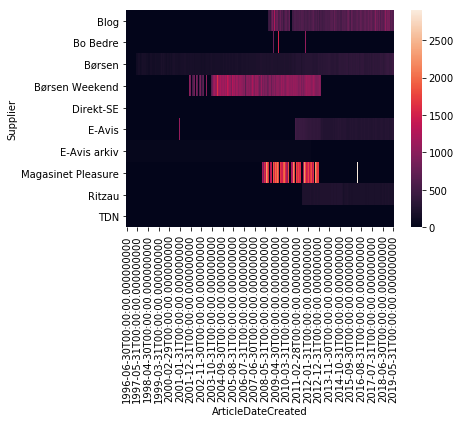

In [105]:
sns.heatmap(word_counts.transpose())